## Notebook 2 in the simulation series

CHB, February 2026

We assume we have obtained the correct beam and receiver gain. We now ingore transmitter stuff and aim to extract the global signal. In the transmitter channels we inpaint with our DPSS model when necessary, but we don't use inpainted data to extract the global signal.

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.dates as mdates
import healpy as hp
from pygdsm import GlobalSkyModel16
from astropy.time import Time

%matplotlib widget

In [33]:
d = np.load("data_models.npz")

data = d["data"]
mask = d["mask"]
times = d["times"]
freqs = d["freqs"]  # MHz
beam_alm = d["beam_alm"]  # beam alm model
beam_hp = d["beam_hp"]  # healpix map of the alm model
g_rx = d["g_rx"]  # receiver gain (mean of beam factored out)
tx_flux = d["tx_flux"]

It is important we define all the processing steps for the data so we can replicate it for synthetic data and 21cm models when we write down likelihoods.

The plan is:

1) Average data across rotations. The optimal weights in the average can be found based on horizon and foreground model, but in practice, we expect uniform weights in azimuth and sine-weights in altitude to be good.

2) Derive foreground modes from simulations using the beam-convovled GSM.

3) Generate suite of 21cm models, fit to the data in the instrument PCA basis. Report model selection constraints.

In [34]:
azalt = np.load("../sim_v003.npz")["azalts"]
az, alt = azalt.T
wgts_sin = np.abs(np.sin(alt))

def avg_rot(data, wgts):
    num = np.sum(data * wgts[None, :, None], axis=1)
    den = np.sum(wgts)
    return num / den

In [35]:
davg = avg_rot(data, wgts_sin)

In [36]:
times_dt = Time(times, format="jd").to_datetime()

def waterfall(data, times=times_dt, freqs=freqs, log=False, vmin=None, vmax=None, cmap="plasma", scale=1e7, title=None, fname=None):
    if vmin is not None:
        vmin /= scale
    if vmax is not None:
        vmax /= scale
    if log:
        norm = colors.LogNorm(vmin=vmin, vmax=vmax)
    else:
        norm = colors.Normalize(vmin=vmin, vmax=vmax)
    plt.figure()
    X, Y = np.meshgrid(freqs, times_dt)
    cmap = plt.get_cmap(cmap)
    cmap.set_over("0.75")
    plt.pcolormesh(X, Y, data / scale, rasterized=True, shading="nearest",cmap=cmap, norm=norm)
    plt.gca().yaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    plt.colorbar(label="Uncalibrated Amplitude [arb. linear units]", extend="both")
    plt.ylabel("Local Time")
    plt.xlabel("Frequency [MHz]")
    if title:
        plt.title(title)
    if fname is not None:
        plt.savefig(fname)
    plt.show()

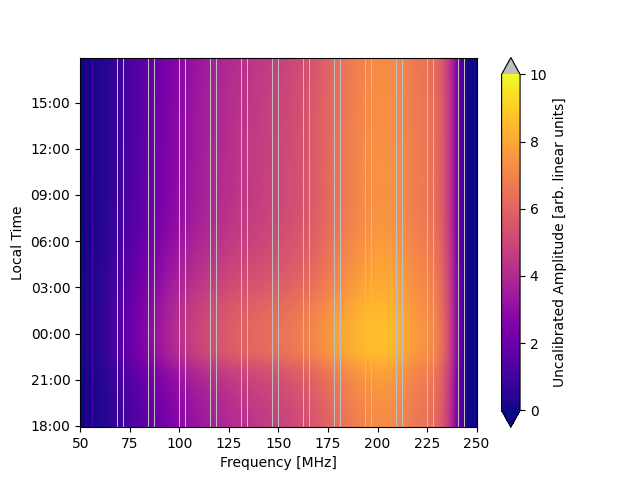

In [47]:
waterfall(davg, vmax=1e8)